# Module 2 project
*Laura Lewis, March 2019*

Overall goal - use the Northwind database to extract useful insights for the company. Northwind database is... Microsoft... etc... Specifically, asking four questions:

1. Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

2. Do customers in different regions tend to order more or less expensive products?

3. question

4. question

***

## Obtaining and scrubbing the data

In this section, the data required to answer the questions will be imported using SQLAlchemy. Then the datasets will be cleaned so that exploratory analysis and statistical tests are able to be conducted in the following sections.

In [216]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

The database schema is illustrated below. This was used to determine what data was required and how to extract it.

![title](Northwind_ERD.png)

In [10]:
# Creating an engine and connecting to a database with SQLAlchemy
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()

2019-03-05 11:32:39,846 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-03-05 11:32:39,848 INFO sqlalchemy.engine.base.Engine ()
2019-03-05 11:32:39,849 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-03-05 11:32:39,851 INFO sqlalchemy.engine.base.Engine ()


In [43]:
# Getting the table names
inspector.get_table_names()

['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

### Question 1 - order details dataset

In this query, we want to extract the quantity of products ordered and the discount level for each order, so we need to group by OrderId. There is also a chance that different discount levels have been applied within the same order, so we also want to group by Discount so that each discount level for each order can be seen (otherwise the query may simply select and display the first Discount value that appears for that order). OrderId refers to the overall ID of the whole order (it is a foreign key, linking to the primary key of the Orders table), whereas Id in the OrderDetails table refers to a sub-order, where there is a separate Id for each individual product within the overall order. This is why we group by OrderId rather than Id.

In [78]:
# Extracting the dataset for question 1 as a pandas dataframe
df1 = pd.read_sql_query("SELECT OrderId, SUM(Quantity) as Total_Quantity, Discount FROM OrderDetail GROUP BY OrderId, Discount", engine)
df1.head()

2019-03-05 13:11:35,101 INFO sqlalchemy.engine.base.Engine SELECT OrderId, SUM(Quantity) as Total_Quantity, Discount FROM OrderDetail GROUP BY OrderId, Discount
2019-03-05 13:11:35,101 INFO sqlalchemy.engine.base.Engine ()


,OrderId,Total_Quantity,Discount
0,10248,27,0.00
1,10249,49,0.00
2,10250,10,0.00
3,10250,50,0.15
4,10251,20,0.00


In [47]:
# Number of unique OrderIds in the dataset
df1.OrderId.nunique()

830

In [45]:
# Total number of rows in the dataset
len(df1)

1000

There are 830 orders in the dataset, but 1000 rows. Because orders are grouped by discount as well as by order, this means that some orders contain products with different discounts applied (e.g. order 10250 contains 10 items with no discount, and 50 items with a 15% discount). There are multiple ways of dealing with this, e.g. in the case of order 10250 this could be counted as two separate orders, or the discount applied to the majority of items could be used. However, because the purpose of this analysis is to later be able to conduct statistical tests, it is preferable here to drop the rows that could confuse the analysis (e.g. because products are counted as being from separate orders when they were actually placed by the same person at the same time in the same order).

In [79]:
# Dropping all rows containing duplicates of OrderId
df1.drop_duplicates(subset=['OrderId'], keep=False, inplace=True)

In [80]:
# Checking the new length of the dataset and whether duplicates have been dropped
print(len(df1))
print(df1.OrderId.nunique() == len(df1))

667
True


The database can now be inspected for any further necessary cleaning.

In [81]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 667 entries, 0 to 990
Data columns (total 3 columns):
OrderId           667 non-null int64
Total_Quantity    667 non-null int64
Discount          667 non-null float64
dtypes: float64(1), int64(2)
memory usage: 20.8 KB


There are no null values, so no need to replace any values.

### Question 2 - customers, orders and products dataset

In this query, we want to extract for each part of each order the customer region, the number of each product ordered, the unit price and the discount level (for calculating the actual price paid). To do this we need to join the Customer and OrderDetail tables using the Order table.

In [286]:
# Extracting the dataset for question 2 as a pandas dataframe
df2 = pd.read_sql_query("""SELECT c.Region, od.Quantity, od.UnitPrice, od.Discount
    FROM Customer c
    JOIN [Order] o ON c.Id = o.CustomerId
    JOIN OrderDetail od ON od.OrderId = o.Id
    """, engine)
df2.head()

2019-03-05 17:50:28,127 INFO sqlalchemy.engine.base.Engine SELECT c.Region, od.Quantity, od.UnitPrice, od.Discount
    FROM Customer c
    JOIN [Order] o ON c.Id = o.CustomerId
    JOIN OrderDetail od ON od.OrderId = o.Id
    


INFO:sqlalchemy.engine.base.Engine:SELECT c.Region, od.Quantity, od.UnitPrice, od.Discount
    FROM Customer c
    JOIN [Order] o ON c.Id = o.CustomerId
    JOIN OrderDetail od ON od.OrderId = o.Id
    


2019-03-05 17:50:28,128 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


,Region,Quantity,UnitPrice,Discount
0,Western Europe,12,14.0,0.0
1,Western Europe,10,9.8,0.0
2,Western Europe,5,34.8,0.0
3,Western Europe,9,18.6,0.0
4,Western Europe,40,42.4,0.0


In [287]:
len(df2)

2078

In [289]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 4 columns):
Region       2078 non-null object
Quantity     2078 non-null int64
UnitPrice    2078 non-null float64
Discount     2078 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 65.0+ KB


***

## Exploring the data and answering the questions

In this section, for each question the relevant dataset will be explored and the questions will be answered by using the relative statistical test.

### Question 1: Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

To answer the first part of this question, a null and alternate hypothesis first need to be created:

**H<sub>0</sub>**: the average number of products ordered is the same with and without a discount

**H<sub>a</sub>**: the average number of products ordered with a discount is either higher or lower than orders without a discount

This question will be answered using the data from the OrderDetail table, which includes data on the number of products in an order and their discount level, and is stored in df1.

The alpha level (i.e. the probability of rejecting the null hypothesis when it is true) will be set at 0.05.

The null and alternate hypotheses refer to orders either with or without a discount. An additional column will be added to bin discount levels into orders where the discount is 0 (no discount) and orders with a discount greater than 0 (has a discount).

In [82]:
# Binning discount levels into 1 (discount) and 0 (no discount)
df1['Discount_bin'] = df1['Discount'].apply(lambda x: 1 if x > 0 else 0)

#### Data exploration

Discounts range from 5% off to 25% off. The vast majority of orders have no discount. However, the average number of items per order with any level of discount is higher than for orders with no discount, although this does not appear to be a consistently increasing pattern.

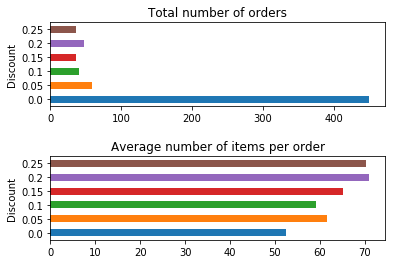

In [205]:
# Plotting the number of orders and average quantity of items per order for orders with different levels of discount
fig, (ax1, ax2) = plt.subplots(2, 1)
df1.groupby(['Discount'])['Total_Quantity'].count().plot(kind='barh', ax=ax1)
df1.groupby(['Discount'])['Total_Quantity'].mean().plot(kind='barh', ax=ax2)
ax1.set_title('Total number of orders')
ax1.set_ylabel('Discount')
ax2.set_ylabel('Discount')
ax2.set_title('Average number of items per order')
fig.subplots_adjust(hspace=0.6);

Another way of viewing this pattern, in a form that has more relevance for the particular null and alternate hypotheses under consideration, is to group orders by those with and without discounts. Although about twice as many orders have no discount compared to some level of discount, orders with a discount contain more items on average (65 items on average for orders with a discount, vs. 52 for orders with no discount). This lends support to the alternate hypothesis that the number of items per order is different for orders with discounts vs. no discounts. 

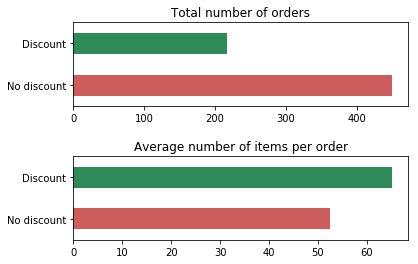

In [184]:
# Plotting the number of orders and average quantity of items per order for orders with and without discounts
fig, (ax1, ax2) = plt.subplots(2, 1)
df1.groupby(['Discount_bin'])['Total_Quantity'].count().plot(kind='barh', ax=ax1, color=['indianred', 'seagreen'])
df1.groupby(['Discount_bin'])['Total_Quantity'].mean().plot(kind='barh', ax=ax2, color=['indianred', 'seagreen'])
ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax2.set_title('Average number of items per order')
ax1.set_yticklabels(['No discount', 'Discount'])
ax2.set_yticklabels(['No discount', 'Discount'])
fig.subplots_adjust(hspace=0.6);

In [157]:
# Average number of items for orders with and without a discount
round(df1.groupby(['Discount_bin'])['Total_Quantity'].mean(),0)

Discount_bin
0    52.0
1    65.0
Name: Total_Quantity, dtype: float64

#### Answering the question

In order to answer this question with a degree of rigour, we must use statistical tests rather than just descriptive statistics. The correct hypothesis test needs to be chosen. In this case, a two-tailed t-test will be used. This is because the data is continuous, and because we are looking for either a decrease _or_ an increase in the number of products ordered.

A two-sample t-test assumes that the data is normally distributed, and that the samples have equal variances. This can be assessed with distribution plots:

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


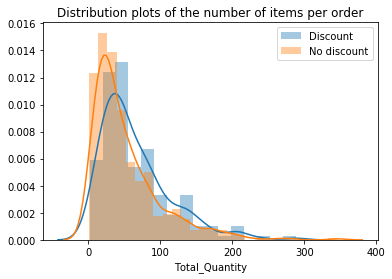

In [173]:
# Separating the dataset into orders with and without discounts, and assessing their distributions.
discount = df1[df1['Discount_bin'] == 1]
no_discount = df1[df1['Discount_bin'] == 0]
sns.distplot(discount.Total_Quantity, label='Discount')
sns.distplot(no_discount.Total_Quantity, label='No discount')
plt.title('Distribution plots of the number of items per order')
plt.legend();

The distribution plots above show that these assumptions hold true, and so a standard t-test can be used (as opposed to a Welch's t-test).

In [174]:
# Running a two-sided t-test to compare two independent samples
stats.ttest_ind(discount.Total_Quantity, no_discount.Total_Quantity)

Ttest_indResult(statistic=3.1998176433298506, pvalue=0.0014405227760355727)

In [215]:
print("Average items per order for orders with no discounts: ", round(no_discount['Total_Quantity'].mean(),1))
print("Average items per order for orders with discounts: ", round(discount['Total_Quantity'].mean(),1))
print("Effect size: ", round(discount['Total_Quantity'].mean() - no_discount['Total_Quantity'].mean(),1))
print("Relative effect size (increase from no discount to discount): ", round(((discount['Total_Quantity'].mean() - no_discount['Total_Quantity'].mean())/no_discount['Total_Quantity'].mean())*100,1))

Average items per order for orders with no discounts:  52.4
Average items per order for orders with discounts:  65.3
Effect size:  12.8
Relative effect size (increase from no discount to discount):  24.4


The p-value is 0.001, which is less than our alpha value of 0.05. Therefore we can reject the null hypothesis and accept the alternative hypothesis. We can conclude that there is a statistically significant difference between the average number of items per order for orders with and without discounts, i.e. offering a discount does change the number of items that a customer orders.

**On average:**

 - **There are 52 items per order with no discount, and 65 items per order with a discount**

 - **Orders with discounts contain 13 more items than orders with no discounts, which is a 24% increase.**

**However, these correlations do not necessarily imply causation, and so it is not possible to categorically state that offering a discount will necessarily increase the order size by 24%.**

The second part of the question asks at what level of discount the statistically significant effect occurs. To answer this part of this question, a new null and alternate hypothesis need to be created:

**H<sub>0</sub>**: the average number of products ordered is the same at different levels of discount

**H<sub>a</sub>**: the average number of products ordered is different between the different levels of discount

The alpha level (i.e. the probability of rejecting the null hypothesis when it is true) will be set at 0.05.

To answer this question, ANOVA will be used in order to assess the degree of variation between multiple samples, where each sample is a different level of discount.

In [224]:
# Fitting a model of Total_Quantity on Discount categories, and using statsmodels to compute an ANOVA table
lm = ols('Total_Quantity ~ C(Discount)', discount).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(Discount),4.0,4673.859574,1168.464893,0.486108,0.745935
Residual,212.0,509587.200334,2403.713209,NaN,NaN


In [219]:
# Summary of the model and its coefficients
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Total_Quantity   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.4861
Date:                Tue, 05 Mar 2019   Prob (F-statistic):              0.746
Time:                        16:35:26   Log-Likelihood:                -1150.0
No. Observations:                 217   AIC:                             2310.
Df Residuals:                     212   BIC:                             2327.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              61.6379      6.438      9.575      0.000      48.948      74.328
C(Discount)[T.0.1]     -2.3879     10.077     -0.237      0.813     -22.251      17.475
C(Discount)[T.0.15]     3.5565     10.403      0.342      0.733     -16.949      24.062
C(Discount)[T.0.2]      9.4046      9.622      0.977      0.329      -9.563      28.372
C(Discount)[T.0.25]     8.6121     10.403      0.828      0.409     -11.894      29.118
==============================================================================
Omnibus:                       64.115   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.741
Skew:                           1.433   Prob(JB):                     2.47e-29
Kurtosis:                       5.520   Cond. No.                         5.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The ANOVA table above reveals that the p-value is 0.746, which is much higher than our alpha value of 0.05. Therefore we cannot reject the null hypothesis that there is no difference between the average number of items per order between different discount levels. The model summary table below that provides further evidence for this conclusion. The p-values for each pairwise comparison between the lowest level of discount (5%) and each other level of discount are all above the alpha value, indicating that no individual discount levels have a statistically significant effect. Additionally, the overall r/eta squared value for the model is negligible, confirming that the different discount levels do not explain the differences in the numbers of items per order in the different groups.

**To conclude, although having a discount has a statistically significant effect on the number of items per order, there is no statistically significant effect from increasing the level of discount. A preliminary conclusion is that the impact of offering any discount at all (e.g. only 5%) on an order is greater than the impact of increasing the level of discount offered (a conclusion supported by the literature on behavioural economics). So an actionable insight for the business could be to offer more low-value discounts, and reduce the number of higher-level discounts. However, further analysis would be needed in order to provide further evidence that the differences in the number of items per order was due primarily to discount level rather than other factors (e.g. by ruling out the impacts of other features, such as different orders containing different types of products).**

### Question 2: Do customers in different regions tend to order more or less expensive products?